In [6]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mstats
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve, 
    roc_auc_score, 
    roc_curve,
)
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.svm import SVC

# Configs

In [7]:
project_root = "/Users/feiyixie/Projects/Summer-2024-ECE-597-Group8"
random_state = 42
test_size = 0.1

In [8]:
df = pd.read_csv(
    os.path.join(project_root, "data", "processed", "features_word2Vec_labels.csv")
)

# Experiments

In [9]:
def evaluate_model(model, X, y, cv=3):
    """
    Evaluates the performance of a binary classifier using cross-validation.

    Args:
    model (estimator): The machine learning model to evaluate.
    X (DataFrame or array-like): Feature data used for training the model.
    y (array-like): True labels.
    cv (int): Number of cross-validation folds.

    Returns:
    None
    """
    # Get decision function scores via cross-validation
    y_scores = cross_val_predict(model, X, y, cv=cv)
    # y_scores = cross_val_predict(model, X, y, cv=cv, method='decision_function')

    # Convert decision scores to binary predictions using 0 as a threshold
    y_pred = (y_scores > 0).astype(int)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y, y_pred))

    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    # Calculate and print accuracy
    accuracy = accuracy_score(y, y_pred)
    print(f"Accuracy: {accuracy:.2f}")

    # Calculate ROC-AUC and Precision-Recall
    roc_auc = roc_auc_score(y, y_scores)
    average_precision = average_precision_score(y, y_scores)

    # Print ROC-AUC and Average Precision-Recall scores
    print(f"ROC-AUC Score: {roc_auc:.2f}")
    print(f"Average Precision-Recall Score: {average_precision:.2f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Random predictions curve
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y, y_scores)
    plt.figure()
    plt.plot(recall, precision, label=f'Precision-Recall curve (area = {average_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
    plt.show()

In [10]:
other_features = [
    "Word_Count",
    "Homoglyphs",
    "Total_Abnormal_Count",
    "html_tags",
    "js_code",
]

X = df.drop(columns=["Label"])
X = X.drop(columns=other_features)
y = df["Label"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state
)

In [11]:
# Define a preprocessing pipeline for word2Vec features
preprocessor = make_pipeline(
    StandardScaler()
)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     23122
           1       0.93      0.26      0.41      2330

    accuracy                           0.93     25452
   macro avg       0.93      0.63      0.68     25452
weighted avg       0.93      0.93      0.91     25452

Confusion Matrix:
[[23078    44]
 [ 1725   605]]
Accuracy: 0.93
ROC-AUC Score: 0.63
Average Precision-Recall Score: 0.31


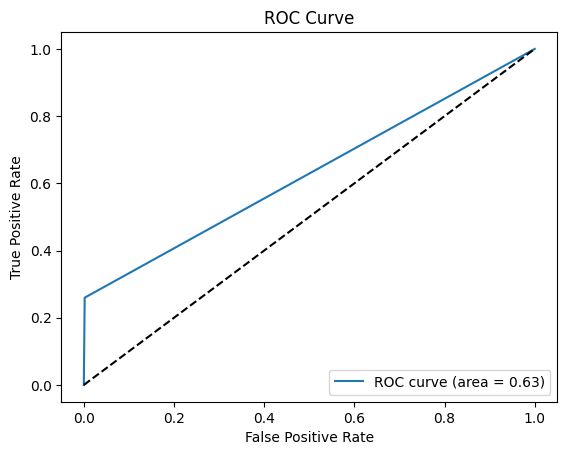

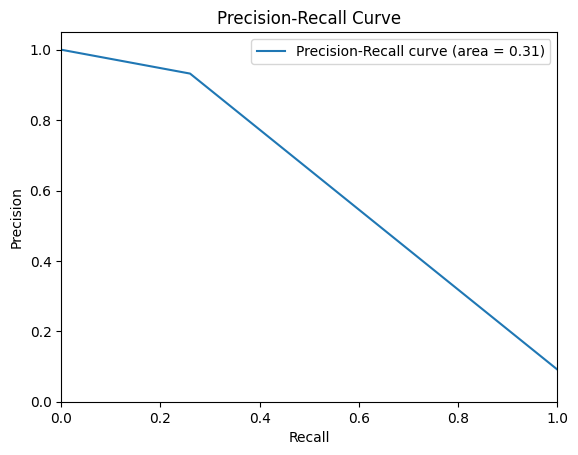

In [19]:
model_SVC = make_pipeline(
    preprocessor,
    SVC(
        C=1.0, kernel="rbf", gamma="scale", random_state=random_state
    ),
)

model_SVC.fit(X_train, y_train)
evaluate_model(model_SVC, X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     23122
           1       0.96      0.33      0.50      2330

    accuracy                           0.94     25452
   macro avg       0.95      0.67      0.73     25452
weighted avg       0.94      0.94      0.92     25452

Confusion Matrix:
[[23093    29]
 [ 1550   780]]
Accuracy: 0.94
ROC-AUC Score: 0.67
Average Precision-Recall Score: 0.38


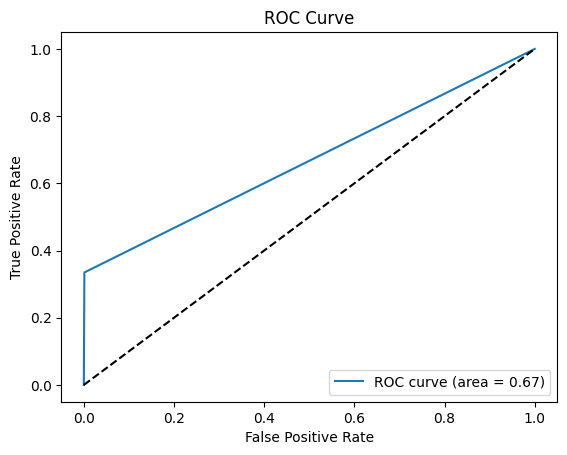

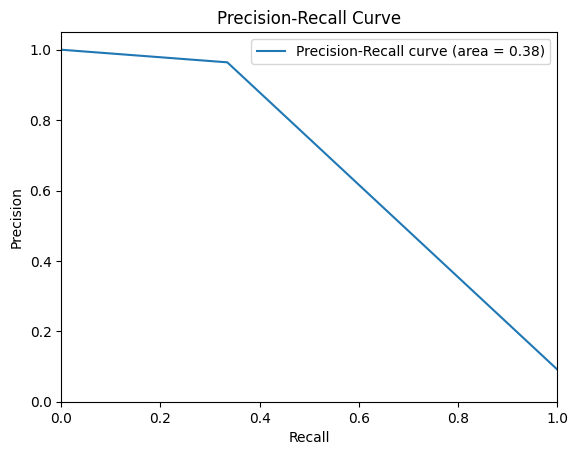

In [20]:
# Use random forest classifier
model_RF = make_pipeline(
    # preprocessor,
    RandomForestClassifier(
        n_estimators=100, random_state=random_state
    ),
)

model_RF.fit(X_train, y_train)
evaluate_model(model_RF, X_train, y_train)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     23122
           1       0.59      0.51      0.54      2330

    accuracy                           0.92     25452
   macro avg       0.77      0.74      0.75     25452
weighted avg       0.92      0.92      0.92     25452

Confusion Matrix:
[[22291   831]
 [ 1146  1184]]
Accuracy: 0.92
ROC-AUC Score: 0.74
Average Precision-Recall Score: 0.34


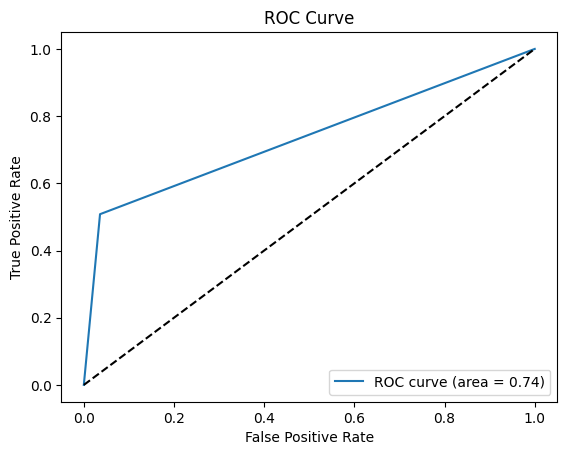

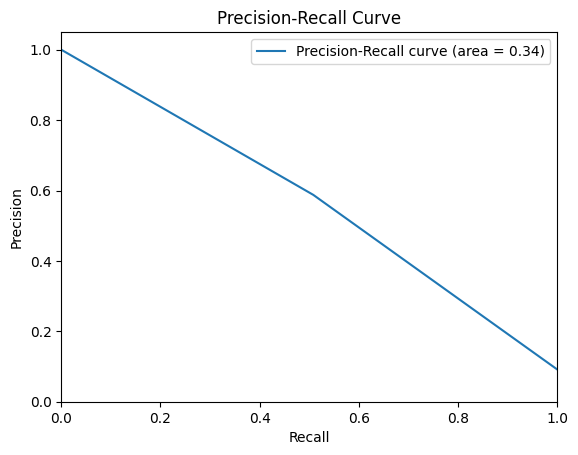

In [21]:
# Use decision tree classifier
from sklearn.tree import DecisionTreeClassifier

model_DT = make_pipeline(
    # preprocessor,
    DecisionTreeClassifier(random_state=random_state),
)

model_DT.fit(X_train, y_train)
evaluate_model(model_DT, X_train, y_train)

In [22]:
from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
import keras
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import numpy as np

# Define a function to create the Keras model
def create_model():
    model = Sequential()
    model.add(SimpleRNN(units=50, input_shape=(100, 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Custom transformer to reshape the data
class Reshaper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.reshape((X.shape[0], X.shape[1], 1))

# Standardize the data before reshaping
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)

# Reshape the scaled data to 3D [samples, timesteps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

# Wrap the Keras model with KerasClassifier
keras_classifier = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)

# Train the Keras model directly (since Pipeline cannot handle 3D input directly)
keras_classifier.fit(X_train_reshaped, y_train.values)

# Make predictions
y_pred = keras_classifier.predict(X_train_reshaped)

# Generate the classification report
print(classification_report(y_train.values, y_pred))

/Users/feiyixie/Projects/Summer-2024-ECE-597-Group8/.venv/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/feiyixie/Projects/Summer-2024-ECE-597-Group8/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


              precision    recall  f1-score   support

           0       0.93      0.99      0.96     23122
           1       0.82      0.29      0.43      2330

    accuracy                           0.93     25452
   macro avg       0.87      0.64      0.69     25452
weighted avg       0.92      0.93      0.91     25452

